In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from sklearn.preprocessing import LabelEncoder
import joblib

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
data = pd.read_csv('/content/drive/MyDrive/data_clean/cars.csv')

In [4]:
data.head()

,nama,harga,jarak_tempuh,tipe_bbm,transmisi,umur
0,Maruti 800 AC,5.400000e+08,70000.0,Petrol,Manual,17
1,Maruti Wagon R LXI Minor,1.215000e+09,50000.0,Petrol,Manual,17
2,Hyundai Verna 1.6 SX,5.400000e+09,100000.0,Diesel,Manual,12
3,Datsun RediGO T Option,3.500000e+09,46000.0,Petrol,Manual,7
4,Honda Amaze VX i-DTEC,6.300000e+09,141000.0,Diesel,Manual,10


In [5]:
data.isnull().sum()

,0
nama,0
harga,0
jarak_tempuh,0
tipe_bbm,0
transmisi,0
umur,0


In [6]:
columns_to_drop = ['jarak_tempuh','umur']
data.drop(columns=columns_to_drop, inplace=True)
print(data.head())

                       nama         harga tipe_bbm transmisi
0             Maruti 800 AC  5.400000e+08   Petrol    Manual
1  Maruti Wagon R LXI Minor  1.215000e+09   Petrol    Manual
2      Hyundai Verna 1.6 SX  5.400000e+09   Diesel    Manual
3    Datsun RediGO T Option  3.500000e+09   Petrol    Manual
4     Honda Amaze VX i-DTEC  6.300000e+09   Diesel    Manual


In [7]:
data['Brand'] = data['nama']

In [8]:
data['price'] = data['harga']

In [9]:
data.drop(columns=['nama'], inplace=True)

In [10]:
data.drop(columns=['harga'], inplace=True)

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3570 entries, 0 to 3569
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   tipe_bbm   3570 non-null   object 
 1   transmisi  3570 non-null   object 
 2   Brand      3570 non-null   object 
 3   price      3570 non-null   float64
dtypes: float64(1), object(3)
memory usage: 111.7+ KB


In [12]:
data.head()

,tipe_bbm,transmisi,Brand,price
0,Petrol,Manual,Maruti 800 AC,5.400000e+08
1,Petrol,Manual,Maruti Wagon R LXI Minor,1.215000e+09
2,Diesel,Manual,Hyundai Verna 1.6 SX,5.400000e+09
3,Petrol,Manual,Datsun RediGO T Option,3.500000e+09
4,Diesel,Manual,Honda Amaze VX i-DTEC,6.300000e+09


In [13]:
data.to_csv('mobil_clean.csv', index=False)
print("Data berhasil disimpan")

Data berhasil disimpan


In [14]:
data['Price_normalized'] = (data['price'] - data['price'].min()) / (data['price'].max() - data['price'].min())

In [15]:
brand_counts = data['Brand'].value_counts()
min_samples = 3
data = data[data['Brand'].isin(brand_counts[brand_counts >= min_samples].index)]

In [16]:
item_group_encoder = LabelEncoder()
data['tipe_bbm'] = item_group_encoder.fit_transform(data['tipe_bbm'])
merek_encoder = LabelEncoder()
data['transmisi'] = merek_encoder.fit_transform(data['transmisi'])

item_group_mapping = dict(zip(item_group_encoder.classes_, range(len(item_group_encoder.classes_))))
merek_mapping = dict(zip(merek_encoder.classes_, range(len(merek_encoder.classes_))))
print(item_group_mapping)
print(merek_mapping)

{'CNG': 0, 'Diesel': 1, 'LPG': 2, 'Petrol': 3}
{'Automatic': 0, 'Manual': 1}


In [17]:
np.random.seed(42)
tf.random.set_seed(42)

In [18]:
n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42)
data['Brand_cluster'] = kmeans.fit_predict(data[['Price_normalized', 'tipe_bbm', 'transmisi']])

In [34]:
joblib.dump(kmeans, 'kmeans_mobil.pkl')
print("Model KMeans telah disimpan")

Model KMeans telah disimpan


In [20]:
cluster_counts = data['Brand_cluster'].value_counts()
valid_clusters = cluster_counts[cluster_counts > 1].index
data = data[data['Brand_cluster'].isin(valid_clusters)]

In [21]:
features = data[['Price_normalized', 'tipe_bbm', 'transmisi']].values
labels = data['Brand_cluster'].values

In [22]:
scaler = StandardScaler()
features = scaler.fit_transform(features)

In [35]:
import joblib
joblib.dump(scaler, 'scaler_mobil.pkl')

['scaler_mobil.pkl']

In [24]:
X_train, X_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.2, random_state=42, stratify=labels
)
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

In [25]:
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(124, activation='relu',
                          kernel_regularizer=regularizers.l2(0.01)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu',
                          kernel_regularizer=regularizers.l2(0.01)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(n_clusters, activation='softmax')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [26]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [27]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=8, min_lr=1e-6)
history = model.fit(X_train, y_train,
                    epochs=100,
                    batch_size=8,
                    validation_split=0.2,
                    class_weight=class_weight_dict,
                    verbose=1,
                    callbacks=[early_stopping, lr_scheduler])

Epoch 1/100
172/172 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.1520 - loss: 3.5803 - val_accuracy: 0.1953 - val_loss: 3.0496 - learning_rate: 1.0000e-04
Epoch 2/100
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2689 - loss: 2.7714 - val_accuracy: 0.3994 - val_loss: 2.5336 - learning_rate: 1.0000e-04
Epoch 3/100
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4605 - loss: 2.2874 - val_accuracy: 0.7988 - val_loss: 1.9188 - learning_rate: 1.0000e-04
Epoch 4/100
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5758 - loss: 1.9509 - val_accuracy: 0.8892 - val_loss: 1.5737 - learning_rate: 1.0000e-04
Epoch 5/100
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6516 - loss: 1.8205 - val_accuracy: 0.9271 - val_loss: 1.4336 - learning_rate: 1.0000e-04
Epoch 6/100
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6822 - loss: 1.7378 - val_accuracy: 0.9271 - val_loss: 1.3558 - learning_rate: 1.0000e-04
Epoch 7/100
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc

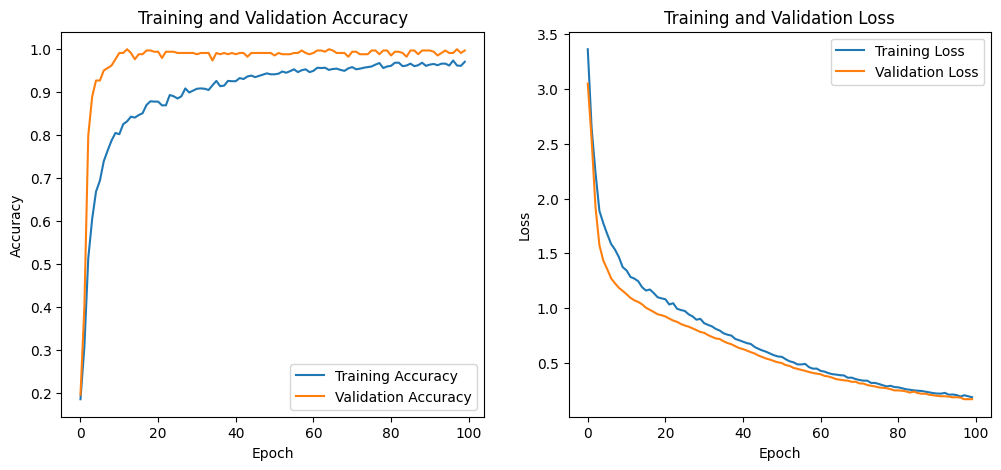

In [28]:
plt.figure(figsize=(12, 5))

# Plot akurasi
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [29]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9905 - loss: 0.1672 
Test Loss: 0.17280462384223938, Test Accuracy: 0.9883449673652649
Test Accuracy: 98.83%


In [30]:
model.save('mobil_fix.h5')

# Testing dengan Filter

In [33]:
# Fungsi untuk merekomendasikan barang berdasarkan budget
def recommend_items(budget, tolerance=0.1, top_n=5):
    # Tentukan rentang harga berdasarkan toleransi
    min_price = budget * (1 - tolerance)
    max_price = budget * (1 + tolerance)

    # Filter data berdasarkan harga25000
    recommendations = data[(data['price'] >= min_price) & (data['price'] <= max_price)]

    # Jika lebih dari top_n, urutkan berdasarkan harga
    if not recommendations.empty:
        recommendations = recommendations.sort_values(
            by=['price'], ascending=True
        ).head(top_n)

    # Jika tidak ada hasil, kembalikan DataFrame kosong
    if recommendations.empty:
        return pd.DataFrame(columns=['Brand','tipe_bbm', 'transmisi', 'price'])

    # Menampilkan label asli untuk item group, merek, dan brand
    recommendations['tipe_bbm'] = item_group_encoder.inverse_transform(recommendations['tipe_bbm'])
    recommendations['transmisi'] = merek_encoder.inverse_transform(recommendations['transmisi'])

    return recommendations[['Brand','tipe_bbm', 'transmisi', 'price']]

# Contoh Penggunaan: User memberikan budget
example_budget = float(input("Masukkan anggaran Anda (dalam IDR): "))
recommendations = recommend_items(example_budget)

if not recommendations.empty:
    print("\nRekomendasi Barang yang Sesuai dengan Budget Anda:")
    print(recommendations)
else:
    print("Tidak ada barang yang sesuai dengan anggaran Anda.")


Masukkan anggaran Anda (dalam IDR): 400000000

Rekomendasi Barang yang Sesuai dengan Budget Anda:
                   Brand tipe_bbm transmisi        price
124       Maruti 800 Std   Petrol    Manual  360000000.0
2317        Tata Nano Lx   Petrol    Manual  360000000.0
2701       Maruti 800 AC   Petrol    Manual  360000000.0
3038       Maruti Zen LX   Petrol    Manual  378000000.0
443   Maruti 800 AC BSII   Petrol    Manual  387000000.0
